In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import torch
import random

##### ADJACENCY DATA

In [3]:
# creating the (degree_inverse@adjacency) matrix for GCN
adjacency = pd.read_csv('/kaggle/input/da324dataminingproject2/adjacency.csv')

adjacency_matrix = adjacency.to_numpy()
degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))

degree_inverse_matrix = np.zeros(degree_matrix.shape)
for node in range(degree_matrix.shape[0]):
    degree_inverse_matrix[node, node] = 1/degree_matrix[node, node]

adjacency_cap = torch.tensor(np.matmul(degree_inverse_matrix, adjacency_matrix))
adjacency_cap = adjacency_cap.to(torch.float32)

##### ATTRIBUTES DATA

In [4]:
attributes = pd.read_excel('/kaggle/input/da324dataminingproject2/attributes.xlsx', sheet_name='in')

# standardizing the attributes
attributes_standardized = (attributes - attributes.mean()) / attributes.std()

# applying pca
pca = PCA(n_components=0.9)  
attributes_pca = pca.fit_transform(attributes_standardized)

# taking it as input of the GCN
input_data = torch.tensor(attributes_pca)
input_data = input_data.to(torch.float32)

##### SEED DATA

In [5]:
seed = pd.read_excel('/kaggle/input/da324dataminingproject2/seed.xlsx', sheet_name='in')
seed.columns = range(len(seed.columns))

# making the column headings as a row
all_seeds = pd.DataFrame(seed.columns).T
all_seeds = pd.concat([all_seeds, seed], axis=0)
all_seeds = all_seeds.reset_index(drop = True)
all_seeds.columns = ["First", "Second", "Third"]

##### MAKING TRAINING DATA FROM SEEDS

In [6]:
training_data = []
for _, row in all_seeds.iterrows():
    training_data.append([row['First'], row['Second']])
    training_data.append([row['Third'], row['Second']])
    training_data.append([row['First'], row['Third']])

training_nodes = all_seeds.to_numpy().reshape(-1)

##### DEFINING THE GCN MODEL

In [7]:
class Custom_model(torch.nn.Module):

    def __init__(self):
        super(Custom_model, self).__init__()

        self.W1 = torch.nn.Linear(input_data.shape[1], 20, bias=False)
        self.B1 = torch.nn.Linear(input_data.shape[1], 20, bias=False)
  
        self.W2 = torch.nn.Linear(20, 10, bias=False)
        self.B2 = torch.nn.Linear(20, 10, bias=False)
        
        self.activation = torch.nn.ReLU()
        
    
    def forward(self, x):
        x = self.W1(torch.matmul(adjacency_cap, x)) + self.B1(x)
        x = self.activation(x)
        x = self.W2(torch.matmul(adjacency_cap, x)) + self.B2(x)
        x = self.activation(x)

        return x

In [8]:
torch.manual_seed(1234)
model = Custom_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

##### DEFINING THE LOSS FUNCTION

In [9]:
negative_samples = 30
def loss_function(output):
    
    loss = 0
    for ind, node_pair in enumerate(training_data):
        
        numerator = torch.dot(output[node_pair[0], :], output[node_pair[1], :])
        denominator_1 = 0
        denominator_2 = 0

        for _ in range(negative_samples):

            node = random.randrange(0, 11952)
            while node in training_nodes[3*int(ind/3):3*int(ind/3)+3]:
                node = random.randrange(0, 11952)

            denominator_1 += torch.dot(output[node_pair[0], :], output[node, :])
            denominator_2 += torch.dot(output[node_pair[1], :], output[node, :])
        
        loss -= torch.log((numerator+0.001)/(denominator_1+0.001))
        loss -= torch.log((numerator+0.001)/(denominator_2+0.001))
        
    return loss 

##### TRAINING THE GCN MODEL

In [10]:
num_epochs = 30
minimum_loss = np.inf
losses = []

for epoch in range(num_epochs):

    output = model(input_data)
    loss = loss_function(output)

    losses.append(loss)
    if loss < minimum_loss:
        torch.save(model.state_dict(), '/model.pt')
    if epoch%5 == 0:
        print(f"EPOCH {epoch+1}: {loss}\n")

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

EPOCH 1: 214.78524780273438

EPOCH 6: 183.89846801757812

EPOCH 11: 164.40147399902344

EPOCH 16: 148.0687713623047

EPOCH 21: 133.19473266601562

EPOCH 26: 108.92150115966797



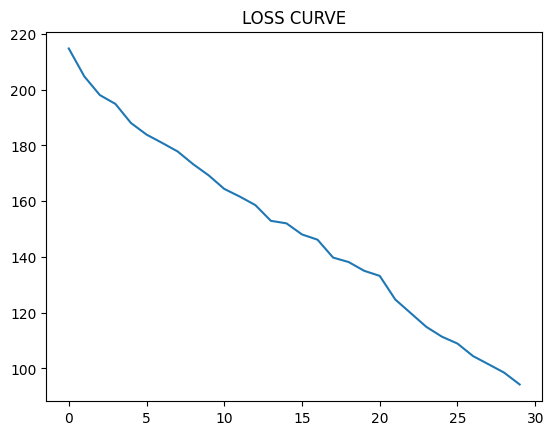

In [11]:
plt.plot([losses[i].detach().numpy() for i in range(num_epochs)])
plt.title("LOSS CURVE")
plt.show()

##### EXTRACTING THE EMBEDDINGS

In [12]:
model.load_state_dict(torch.load('/model.pt'))
embeddings = model(input_data).detach().numpy()
embeddings = pd.DataFrame(embeddings)

##### APPLYING KMEANS

In [13]:
# calculating initial centroids from given seeds' centroid
centroids = np.zeros((10, 10))
for index, row in all_seeds.iterrows():
    centroids[index] = (embeddings.iloc[row['First'], :] +  embeddings.iloc[row['Second'], :] +  embeddings.iloc[row['Third'], :])/3

In [14]:
kmeans = KMeans(n_clusters=10, init=centroids, n_init=1, random_state=0)
labels = kmeans.fit_predict(embeddings)
embeddings['cluster'] = labels

##### FINAL SUBMISSION

In [15]:
embeddings.reset_index(inplace=True)
submission_labels = embeddings[['index', 'cluster']].rename(columns={'index': 'ID', 'cluster': 'LABEL'})
submission_labels.to_csv('submission.csv', index=False)